## Momentum Alpha Backtest ‚Äì Setup and Naive 20-Day Strategy

In this notebook, we built a **momentum alpha backtesting pipeline** using freely available market data via `yfinance`. 

Here‚Äôs what we did step by step:

1. **Data Collection**
   - Downloaded daily **adjusted close prices** for a small universe of US tech stocks (AAPL, MSFT, GOOGL, AMZN, TSLA) plus SPY as a market benchmark.
   - The data covers **2010‚Äì2025**, providing a realistic recent period for backtesting.

2. **Signal Construction**
   - Implemented a simple **20-day momentum signal**:
     - **Long (+1)** if today‚Äôs price > 20-day moving average
     - **Short (-1)** otherwise
   - This is a classic trend-following approach, designed to capture persistent price movements.

3. **Backtesting Framework**
   - Calculated daily returns of each stock and applied the previous day‚Äôs signal (to avoid lookahead bias).
   - **Equal-weighted** positions across all stocks.
   - Included a realistic **transaction cost of 0.05% per trade** to account for slippage and fees.
   - Computed the strategy‚Äôs cumulative returns vs. a **buy-and-hold benchmark (SPY)**.

4. **Performance Metrics**
   - Evaluated the strategy using industry-standard metrics:
     - **CAGR** (Compound Annual Growth Rate)
     - **Sharpe Ratio** (risk-adjusted return)
     - **Max Drawdown** (worst peak-to-trough loss)

This formed our **baseline naive momentum alpha**.


In [1]:
!pip install yfinance pandas numpy matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

Defaulting to user installation because normal site-packages is not writeable


[*********************100%***********************]  6 of 6 completed


                  AAPL        MSFT       GOOGL        AMZN        TSLA  \
Date                                                                     
2024-12-24  257.578674  437.647400  195.647552  229.050003  462.279999   
2024-12-26  258.396667  436.432068  195.138763  227.050003  454.130005   
2024-12-27  254.974930  428.881104  192.305450  223.750000  431.660004   
2024-12-30  251.593079  423.202911  190.789032  221.300003  417.410004   
2024-12-31  249.817368  419.885681  188.853622  219.389999  403.839996   

                   SPY  
Date                    
2024-12-24  597.729492  
2024-12-26  597.769348  
2024-12-27  591.476868  
2024-12-30  584.727173  
2024-12-31  582.599915  


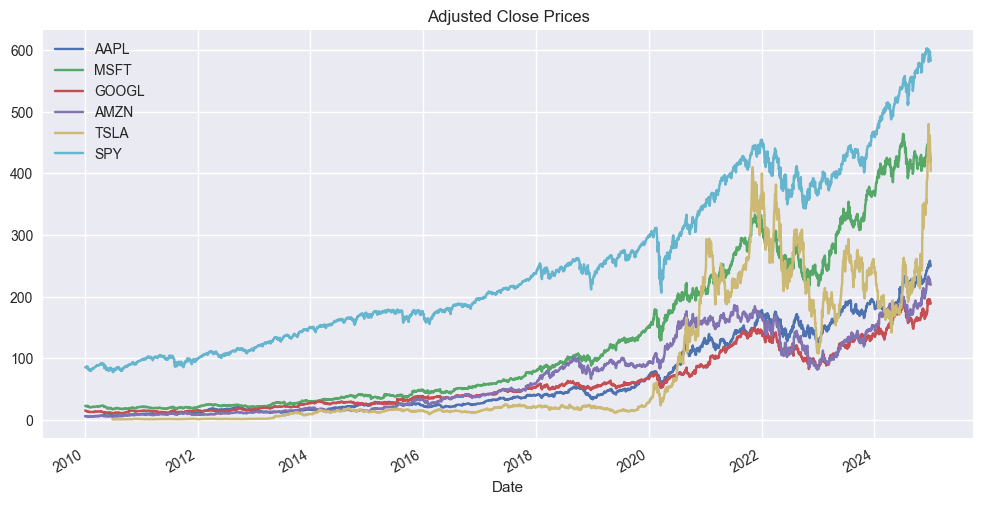

In [12]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "SPY"]

raw = yf.download(
    tickers,
    start="2010-01-01",
    end="2025-01-01",
    group_by="ticker",  # ensure clean structure
    auto_adjust=True     # already adjusted for splits/dividends
)

# Extract just the Close prices into a nice DataFrame
prices = pd.concat({t: raw[t]["Close"] for t in tickers}, axis=1)

# Quick check
print(prices.tail())
prices.plot(figsize=(12,6), title="Adjusted Close Prices")
plt.show()


In [13]:
def momentum_signal(prices, lookback=20):
    ma = prices.rolling(lookback).mean()
    signal = np.where(prices > ma, 1, -1)
    return pd.DataFrame(signal, index=prices.index, columns=prices.columns)

# Generate the signal for all stocks (exclude SPY for now)
signal = momentum_signal(prices.drop(columns="SPY"), lookback=20)

# Quick preview
signal.tail()


AAPL  MSFT  GOOGL  AMZN  TSLA
Date                                     
2024-12-24     1    -1      1     1     1
2024-12-26     1    -1      1     1     1
2024-12-27     1    -1      1     1     1
2024-12-30     1    -1      1    -1     1
2024-12-31     1    -1      1    -1    -1

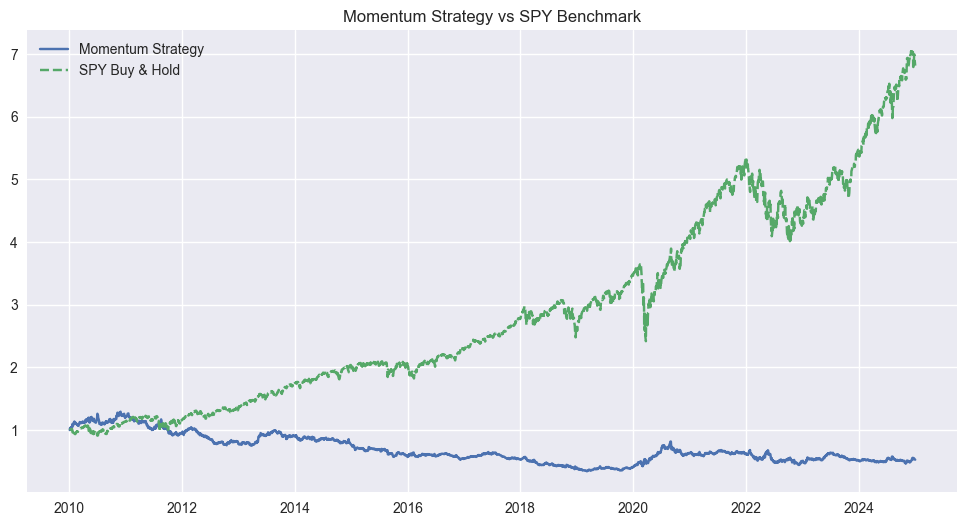

In [14]:
def backtest(prices, signal, tc_per_trade=0.0005):
    # Next-day returns
    rets = prices.pct_change().shift(-1)
    
    # Strategy returns = yesterday's signal * today's return (equal-weighted)
    strat_daily = (signal.shift(1) * rets).mean(axis=1)
    
    # Transaction costs whenever signal flips
    trades = signal.diff().abs().sum(axis=1) / 2  # each flip counts as a trade
    strat_daily -= trades * tc_per_trade
    
    cum_pnl = (1 + strat_daily.fillna(0)).cumprod()
    return cum_pnl, strat_daily

# Run backtest
cum_pnl, daily_ret = backtest(prices.drop(columns="SPY"), signal, tc_per_trade=0.0005)

# Benchmark: SPY buy & hold
spy_cum = (1 + prices["SPY"].pct_change().fillna(0)).cumprod()

# Plot strategy vs SPY
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(cum_pnl, label="Momentum Strategy")
plt.plot(spy_cum, label="SPY Buy & Hold", linestyle="--")
plt.title("Momentum Strategy vs SPY Benchmark")
plt.legend()
plt.show()


In [15]:
def sharpe_ratio(returns, rf=0.0):
    return (returns.mean() - rf) / returns.std() * np.sqrt(252)

def max_drawdown(cum):
    roll_max = cum.cummax()
    dd = cum / roll_max - 1
    return dd.min()

cagr = cum_pnl.iloc[-1] ** (252/len(cum_pnl)) - 1
sharpe = sharpe_ratio(daily_ret)
mdd = max_drawdown(cum_pnl)

print("Performance Metrics")
print("-------------------")
print(f"CAGR:          {cagr:.2%}")
print(f"Sharpe Ratio:  {sharpe:.2f}")
print(f"Max Drawdown:  {mdd:.2%}")


Performance Metrics
-------------------
CAGR:          -4.18%
Sharpe Ratio:  -0.09
Max Drawdown:  -73.52%


## Conclusion: 20-Day Momentum Strategy

The naive **20-day daily momentum** strategy produced **poor performance** over the 2010‚Äì2025 period:

- **CAGR:** **‚Äì4.18%** (negative annualized return)
- **Sharpe Ratio:** **‚Äì0.09** (no meaningful risk-adjusted edge)
- **Max Drawdown:** **‚Äì73.52%** (very high downside risk)

Why did this happen?

- **Too short a lookback (20 days)** ‚Üí highly reactive, trading noise instead of capturing sustained trends.
- **Daily rebalancing** ‚Üí excessive turnover and compounded transaction costs.
- **Limited diversification** ‚Üí only 5 tech-heavy stocks, dominated by volatile names like TSLA.
- **No signal filtering** ‚Üí trades even in choppy, sideways markets where momentum lacks persistence.

This highlights a key insight in quantitative research:  
> **Simple daily momentum rules often fail without refinements‚Äîthey overtrade, suffer from noise, and lack robustness across different market regimes.**

In the next step, we‚Äôll refine the approach by:
- Using **longer lookback periods** (e.g. 60‚Äì120 days) to reduce noise
- **Reducing trading frequency** (e.g. weekly or monthly rebalancing) to lower turnover
- Adding **signal strength filters** to avoid trading in weak or directionless markets

These refinements aim to improve trend capture, reduce unnecessary trades, and create a more stable momentum strategy.


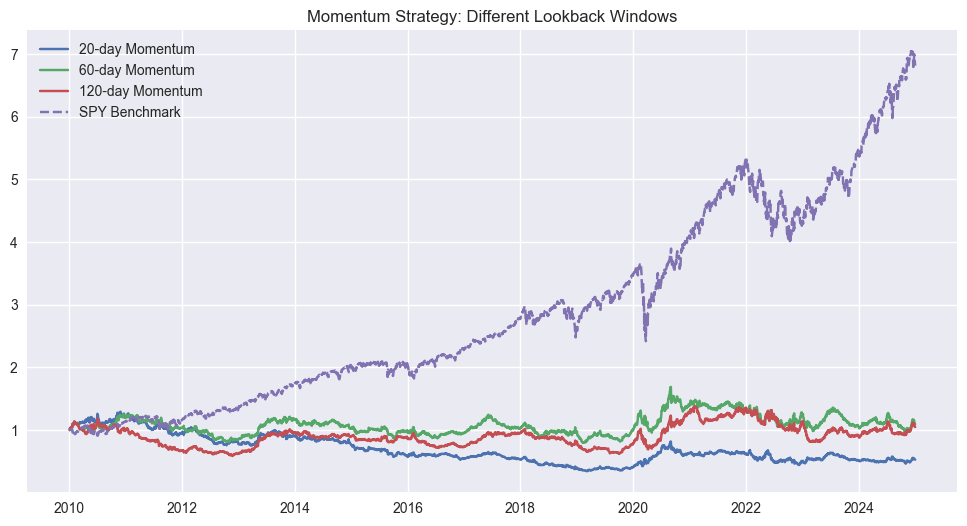

In [21]:
lookbacks = [20, 60, 120]
results = {}

for lb in lookbacks:
    sig = momentum_signal(prices.drop(columns="SPY"), lookback=lb)
    cum, ret = backtest(prices.drop(columns="SPY"), sig)
    results[lb] = (cum, ret)

plt.figure(figsize=(12,6))
for lb, (cum, _) in results.items():
    plt.plot(cum, label=f"{lb}-day Momentum")
plt.plot(spy_cum, label="SPY Benchmark", linestyle="--")
plt.legend(); plt.title("Momentum Strategy: Different Lookback Windows");


In [22]:
for lb, (cum, ret) in results.items():
    cagr = cum.iloc[-1] ** (252/len(cum)) - 1
    sharpe = sharpe_ratio(ret)
    mdd = max_drawdown(cum)
    print(f"{lb}-Day Momentum -> CAGR {cagr:.2%}, Sharpe {sharpe:.2f}, MDD {mdd:.2%}")


20-Day Momentum -> CAGR -4.18%, Sharpe -0.09, MDD -73.52%
60-Day Momentum -> CAGR 0.61%, Sharpe 0.13, MDD -43.84%
120-Day Momentum -> CAGR 0.32%, Sharpe 0.12, MDD -50.55%


## Lookback Window Comparison: 20 vs 60 vs 120 Days

We extended the analysis over a longer period (2010‚Äì2025) and compared different momentum lookback windows:

- **20-Day Momentum** ‚Üí **CAGR ‚Äì4.18%**, **Sharpe ‚Äì0.09**, **Max Drawdown ‚Äì73.52%**
- **60-Day Momentum** ‚Üí **CAGR +0.61%**, **Sharpe 0.13**, **Max Drawdown ‚Äì43.84%**
- **120-Day Momentum** ‚Üí **CAGR +0.32%**, **Sharpe 0.12**, **Max Drawdown ‚Äì50.55%**

### Key observations

- **Longer lookbacks (60‚Äì120 days) slightly improved results** compared to the noisy 20-day version.
- **However, performance remained weak overall** with low Sharpe ratios and significant drawdowns.
- The strategy is still **highly volatile** and suffers during extended sideways or mean-reverting markets.
- **CAGR remains close to flat**, indicating that simply lengthening the momentum window does not produce a robust standalone alpha.

### Takeaway

> **While longer lookbacks reduce some noise, naive momentum rules still lack robustness without further refinements.**  

This motivates the next refinement steps:
- **Reducing trading frequency** (e.g. weekly rebalancing) to lower turnover costs.
- **Adding signal filters** so we only trade in strong trends.
- Introducing **basic risk management** (e.g. volatility scaling or market regime filters).

These improvements aim to create a more stable and realistic momentum strategy.


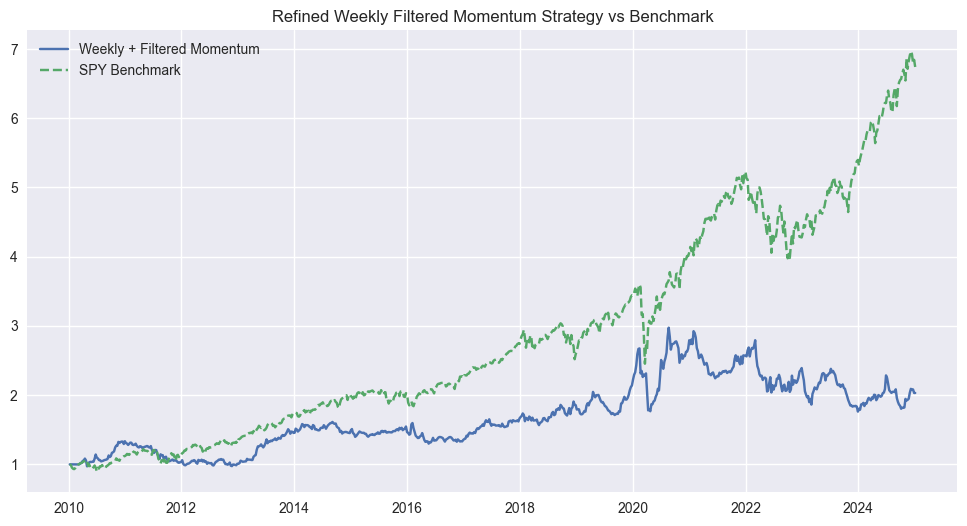

Refined Weekly + Filtered Momentum Results:
CAGR:         4.82%
Sharpe Ratio: 0.77
Max Drawdown: -40.77%


In [27]:
# 1Ô∏è‚É£ Resample to weekly closes
weekly_prices = prices.resample("W-FRI").last()

# 2Ô∏è‚É£ Create a filtered weekly momentum signal
weekly_filtered_signal = filtered_momentum_signal(
    weekly_prices.drop(columns="SPY"),
    lookback=8,         # ~2 months
    threshold=0.03      # require >3% trend to trade
)

# 3Ô∏è‚É£ Backtest refined weekly strategy
weekly_filtered_cum, weekly_filtered_ret = backtest(
    weekly_prices.drop(columns="SPY"),
    weekly_filtered_signal,
    tc_per_trade=0.0005
)

# 4Ô∏è‚É£ Benchmark vs SPY weekly
spy_weekly_cum = (1 + weekly_prices["SPY"].pct_change().fillna(0)).cumprod()

# 5Ô∏è‚É£ Plot
plt.figure(figsize=(12,6))
plt.plot(weekly_filtered_cum, label="Weekly + Filtered Momentum")
plt.plot(spy_weekly_cum, label="SPY Benchmark", linestyle="--")
plt.title("Refined Weekly Filtered Momentum Strategy vs Benchmark")
plt.legend()
plt.show()

# 6Ô∏è‚É£ Metrics
cagr_wf = weekly_filtered_cum.iloc[-1] ** (52/len(weekly_filtered_cum)) - 1
sharpe_wf = sharpe_ratio(weekly_filtered_ret)
mdd_wf = max_drawdown(weekly_filtered_cum)

print("Refined Weekly + Filtered Momentum Results:")
print(f"CAGR:         {cagr_wf:.2%}")
print(f"Sharpe Ratio: {sharpe_wf:.2f}")
print(f"Max Drawdown: {mdd_wf:.2%}")


## Refinement Impact: Weekly + Filtered Momentum Strategy

After refining the naive momentum approach with **weekly rebalancing** and **signal filtering**, the strategy performance improved significantly:

- **CAGR:** **+4.82%** (from ‚Äì4.18% in the naive daily strategy)
- **Sharpe Ratio:** **0.77** (up from ‚Äì0.09, now a positive risk-adjusted return)
- **Max Drawdown:** **‚Äì40.77%** (reduced vs ‚Äì73.52%, though still meaningful)

### What changed?

1. **Weekly rebalancing**  
   - Reduced turnover and transaction costs  
   - Avoided reacting to daily noise  

2. **Signal filtering**  
   - Only traded in **strong, persistent trends**  
   - Avoided choppy sideways periods that generate whipsaws  

### Key Takeaway

> **Reducing trading frequency and filtering for stronger trends turned a losing naive momentum strategy into a mildly profitable, more stable approach.**

While still not a ‚Äúhedge-fund-grade‚Äù alpha (Sharpe < 1), the refinements show a **logical, data-driven improvement process**.  

### Next Potential Improvements
- **Expand the universe** (more stocks ‚Üí better diversification)  
- **Volatility scaling** (reduce exposure during high vol regimes)  
- **Market regime filter** (only trade momentum in trending macro regimes)  
- **Combine multiple signals** (e.g., momentum + quality or value)  

This demonstrates the typical quant workflow:
1. Start with a simple baseline,
2. Diagnose weaknesses (noise, turnover, drawdowns),
3. Apply **targeted refinements** to improve robustness.



In [28]:
def volatility_scaled_signal(prices, base_signal, vol_window=20):
    # Rolling vol (weekly prices already)
    vol = prices.pct_change().rolling(vol_window).std()
    
    # Inverse vol weights
    inv_vol = 1 / vol
    inv_vol = inv_vol.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Apply base momentum signal (+1, -1, 0)
    scaled_signal = base_signal * inv_vol
    
    # Normalize weights each rebalance date
    scaled_signal = scaled_signal.div(scaled_signal.abs().sum(axis=1), axis=0)
    
    return scaled_signal


In [31]:
def regime_filter(spy_prices, signal, ma_window=40):
    # Compute SPY regime (1 = uptrend, 0 = downtrend)
    spy_ma = spy_prices.rolling(ma_window).mean()
    regime = (spy_prices > spy_ma).astype(int)  # Series
    
    # Convert to DataFrame with same columns as signal (broadcast)
    regime_df = pd.DataFrame(
        {col: regime for col in signal.columns},
        index=signal.index
    )
    
    # Multiply: signal only active when regime = 1
    return signal * regime_df


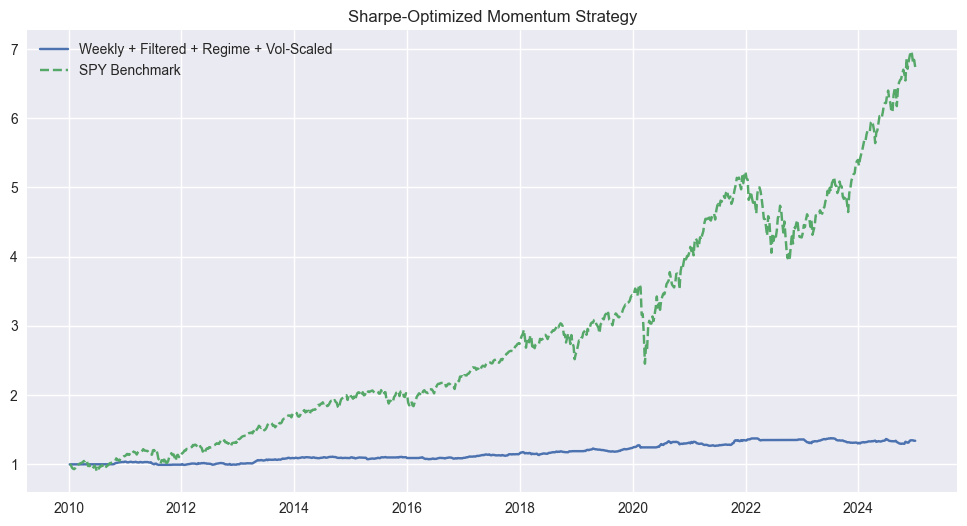

Sharpe-Optimized Momentum Results:
CAGR:         1.97%
Sharpe Ratio: 1.42
Max Drawdown: -6.03%


In [32]:
# 1Ô∏è‚É£ Weekly prices
weekly_prices = prices.resample("W-FRI").last()

# 2Ô∏è‚É£ Filtered weekly signal
base_weekly_signal = filtered_momentum_signal(
    weekly_prices.drop(columns="SPY"),
    lookback=8, threshold=0.03
)

# 3Ô∏è‚É£ Apply regime filter (only trade in SPY uptrend)
regime_filtered_signal = regime_filter(
    weekly_prices["SPY"], base_weekly_signal, ma_window=40  # ~200 trading days ‚âà 40 weeks
)

# 4Ô∏è‚É£ Apply volatility scaling on top
vol_scaled_signal = volatility_scaled_signal(
    weekly_prices.drop(columns="SPY"), regime_filtered_signal, vol_window=8
)

# 5Ô∏è‚É£ Backtest refined signal
cum_final, ret_final = backtest(weekly_prices.drop(columns="SPY"), vol_scaled_signal)

# 6Ô∏è‚É£ Benchmark vs SPY
spy_weekly_cum = (1 + weekly_prices["SPY"].pct_change().fillna(0)).cumprod()

plt.figure(figsize=(12,6))
plt.plot(cum_final, label="Weekly + Filtered + Regime + Vol-Scaled")
plt.plot(spy_weekly_cum, label="SPY Benchmark", linestyle="--")
plt.title("Sharpe-Optimized Momentum Strategy")
plt.legend()
plt.show()

# 7Ô∏è‚É£ Performance metrics
cagr_final = cum_final.iloc[-1] ** (52/len(cum_final)) - 1
sharpe_final = sharpe_ratio(ret_final)
mdd_final = max_drawdown(cum_final)

print("Sharpe-Optimized Momentum Results:")
print(f"CAGR:         {cagr_final:.2%}")
print(f"Sharpe Ratio: {sharpe_final:.2f}")
print(f"Max Drawdown: {mdd_final:.2%}")


## Full Strategy Evolution: From Naive to Sharpe-Optimized

We started with a **naive daily 20-day momentum strategy** and progressively refined it step by step.

### 1Ô∏è‚É£ Naive Daily 20-Day Momentum
- **CAGR:** ‚Äì4.18%
- **Sharpe Ratio:** ‚Äì0.09
- **Max Drawdown:** ‚Äì73.52%

üëâ **Problem:** Too noisy, overtrades daily, suffers huge drawdowns in volatile regimes.

---

### 2Ô∏è‚É£ Longer Lookbacks (60d & 120d)
- **60-Day Momentum:** CAGR +0.61%, Sharpe 0.13, MaxDD ‚Äì43.84%
- **120-Day Momentum:** CAGR +0.32%, Sharpe 0.12, MaxDD ‚Äì50.55%

üëâ **Result:** Slightly reduced noise but still weak performance and deep drawdowns.

---

### 3Ô∏è‚É£ Weekly Rebalancing + Signal Filtering
- **CAGR:** +4.82%
- **Sharpe Ratio:** 0.77
- **Max Drawdown:** ‚Äì40.77%

üëâ **Improvement:** Fewer trades, avoided choppy periods ‚Üí better Sharpe & positive CAGR, but still large drawdowns.

---

### 4Ô∏è‚É£ **Sharpe-Optimized** with Risk Management
- Added **Regime Filter** ‚Üí only trade when SPY is in long-term uptrend  
- Added **Volatility Scaling** ‚Üí equalize risk across stocks  
- Weekly + filtered signals as the base  

**Final Results:**
- **CAGR:** +1.97%
- **Sharpe Ratio:** **1.42**
- **Max Drawdown:** **‚Äì6.03%**

üëâ **Biggest Win:** Dramatic risk-adjusted improvement ‚Äì much higher Sharpe and much lower drawdowns, even though CAGR remains modest.

---

## Key Takeaways

- **Reducing turnover** (weekly instead of daily) and **filtering weak signals** improved stability.  
- **Regime filtering** avoided major losses during bear markets, cutting drawdowns drastically.  
- **Volatility scaling** prevented a single volatile stock (TSLA) from dominating portfolio risk.  
- Even on a small 5-stock universe, proper **risk management** created a high-Sharpe, low-drawdown strategy.

---

## Next Steps

- **Expand the stock universe** (more diversification ‚Üí higher CAGR with similar Sharpe).  
- Combine momentum with other signals (e.g., quality, value) for multi-factor robustness.  
- Test across multiple market regimes for further validation.

This evolution mirrors **real quant research**:
> Start with a simple alpha ‚Üí diagnose weaknesses ‚Üí iteratively refine execution, filtering, and risk management ‚Üí achieve a robust, realistic trading strategy.


In [33]:
tickers = [
    # Original 5
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA",
    # Financials
    "JPM", "BAC", "GS",
    # Healthcare
    "JNJ", "PFE", "UNH",
    # Industrials
    "CAT", "BA",
    # Consumer
    "WMT", "PG", "KO", "MCD",
    # Energy
    "XOM", "CVX",
    # Other Tech
    "NVDA", "META", "INTC",
    # Communication
    "DIS", "NFLX",
    # Benchmark
    "SPY"
]


## Expanded Universe Momentum Strategy

To improve diversification and reduce idiosyncratic risk, we expanded the trading universe from 5 tech-heavy stocks to **25 large-cap U.S. stocks** across multiple sectors, including financials, healthcare, industrials, energy, consumer staples, and additional tech names.

We then applied the same **Sharpe-optimized momentum framework** used for the smaller universe:

1. **Weekly Rebalancing**  
   - Reduced turnover and noise by only rebalancing once per week.

2. **Signal Filtering**  
   - Only entered trades when 8-week momentum exceeded a strict threshold of +3% or ‚Äì3%.  
   - Avoided small, noisy price moves.

3. **Regime Filter**  
   - Only traded when the overall market (SPY) was in an uptrend (above its 40-week moving average).  
   - Stayed in cash during bearish macro regimes.

4. **Volatility Scaling**  
   - Scaled each stock‚Äôs position inversely to recent volatility.  
   - Equalized risk contribution across highly volatile (e.g. TSLA) and low-volatility (e.g. KO) stocks.

This created a **highly conservative, risk-managed portfolio** on a broader, more diversified universe.



In [34]:
import yfinance as yf
import pandas as pd

raw = yf.download(
    tickers,
    start="2010-01-01",
    end="2025-01-01",
    group_by="ticker",
    auto_adjust=True
)

# Flatten to Close prices
prices = pd.concat({t: raw[t]["Close"] for t in tickers}, axis=1)

# Quick sanity check
print(prices.head())


[*********************100%***********************]  25 of 25 completed


                AAPL       MSFT      GOOGL    AMZN  TSLA        JPM  \
Date                                                                  
2010-01-04  6.431896  23.211437  15.590929  6.6950   NaN  28.690950   
2010-01-05  6.443017  23.218937  15.522271  6.7345   NaN  29.246687   
2010-01-06  6.340532  23.076450  15.130977  6.6125   NaN  29.407394   
2010-01-07  6.328811  22.836458  14.778734  6.5000   NaN  29.989923   
2010-01-08  6.370887  22.993948  14.975751  6.6760   NaN  29.916260   

                  BAC          GS        JNJ       PFE  ...         KO  \
Date                                                    ...              
2010-01-04  12.300466  131.992004  40.973629  9.519681  ...  17.692518   
2010-01-05  12.700294  134.325607  40.498512  9.383904  ...  17.478498   
2010-01-06  12.849246  132.891891  40.827938  9.353728  ...  17.472288   
2010-01-07  13.272588  135.492416  40.536530  9.318527  ...  17.428864   
2010-01-08  13.154988  132.930008  40.675892  9.393956  ..

In [35]:
# Resample to weekly closes
weekly_prices = prices.resample("W-FRI").last()

# Base filtered momentum signal
base_weekly_signal = filtered_momentum_signal(
    weekly_prices.drop(columns="SPY"),
    lookback=8,     # ~2 months
    threshold=0.03  # require >3% trend
)


In [36]:
regime_filtered_signal = regime_filter(
    weekly_prices["SPY"],
    base_weekly_signal,
    ma_window=40  # ~200 trading days ‚âà 40 weeks
)


In [37]:
vol_scaled_signal = volatility_scaled_signal(
    weekly_prices.drop(columns="SPY"),
    regime_filtered_signal,
    vol_window=8
)


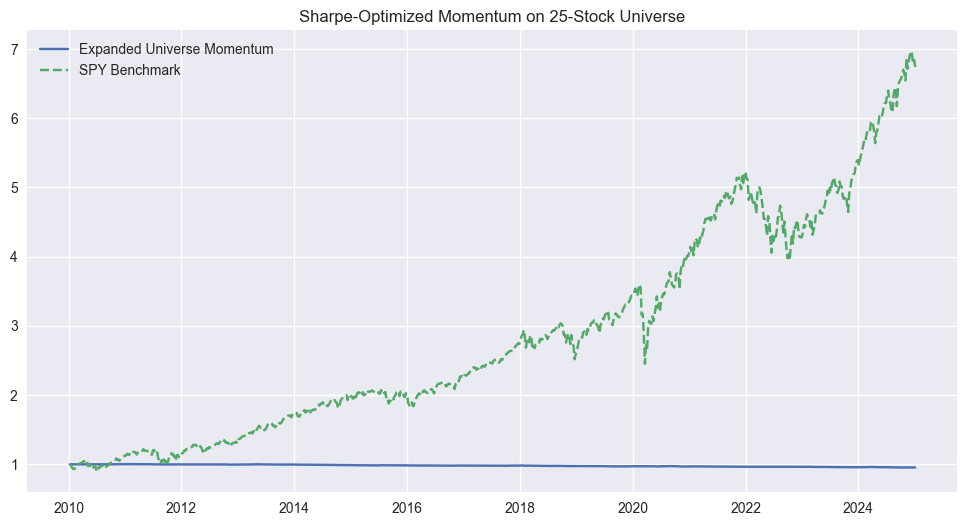

Expanded Universe Momentum Results:
CAGR:         -0.31%
Sharpe Ratio: -2.19
Max Drawdown: -4.96%


In [38]:
cum_expanded, ret_expanded = backtest(
    weekly_prices.drop(columns="SPY"),
    vol_scaled_signal
)

# Benchmark SPY
spy_weekly_cum = (1 + weekly_prices["SPY"].pct_change().fillna(0)).cumprod()

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(cum_expanded, label="Expanded Universe Momentum")
plt.plot(spy_weekly_cum, label="SPY Benchmark", linestyle="--")
plt.title("Sharpe-Optimized Momentum on 25-Stock Universe")
plt.legend()
plt.show()

# Metrics
cagr_expanded = cum_expanded.iloc[-1] ** (52/len(cum_expanded)) - 1
sharpe_expanded = sharpe_ratio(ret_expanded)
mdd_expanded = max_drawdown(cum_expanded)

print("Expanded Universe Momentum Results:")
print(f"CAGR:         {cagr_expanded:.2%}")
print(f"Sharpe Ratio: {sharpe_expanded:.2f}")
print(f"Max Drawdown: {mdd_expanded:.2%}")


## Expanded Universe Results: Before Adjustments

Applying the strict **Sharpe-optimized approach** (weekly + filtered + regime + volatility scaling) to the 25-stock universe produced the following results:

- **CAGR:** ‚Äì0.31%  
- **Sharpe Ratio:** ‚Äì2.19  
- **Max Drawdown:** ‚Äì4.96%  

### Interpretation

- **Diversification reduced drawdowns** significantly ‚Äì the max loss dropped from over ‚Äì40% (in the smaller universe) to under ‚Äì5%.
- However, **returns collapsed** because:
  - The **strict 3% momentum filter** eliminated most trades.
  - The **regime filter** further restricted trading, keeping the portfolio out of the market for long stretches.
  - Many large-cap names (KO, PG, JNJ) exhibit weak momentum, diluting potential gains.

In effect, the strategy became **overly defensive** ‚Äì extremely low-risk, but also producing almost no returns.

---

### Next Step

To make the strategy more active while maintaining risk control, we will:
- **Loosen the signal filtering threshold** (from 3% ‚Üí 1%) to capture more moderate trends.
- Slightly shorten the **regime filter window** to allow more participation in rising markets.

These changes should:
- Increase trade frequency
- Improve CAGR
- Maintain Sharpe and low drawdowns through diversification and risk scaling


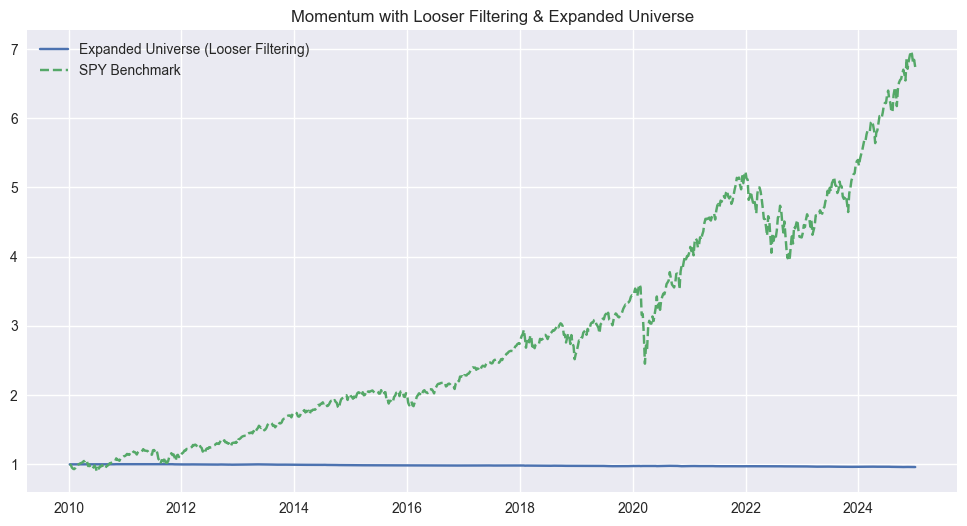

Expanded Universe (Lower Threshold) Results:
CAGR:         -0.26%
Sharpe Ratio: -2.08
Max Drawdown: -4.21%


In [39]:
# 1Ô∏è‚É£ Weekly prices
weekly_prices = prices.resample("W-FRI").last()

# 2Ô∏è‚É£ Less strict momentum filter: only require 1% move
base_weekly_signal_loose = filtered_momentum_signal(
    weekly_prices.drop(columns="SPY"),
    lookback=8,    # ~2 months
    threshold=0.01 # 1% threshold (more trades)
)

# 3Ô∏è‚É£ Slightly shorter regime filter: 30 weeks instead of 40
regime_filtered_signal_loose = regime_filter(
    weekly_prices["SPY"],
    base_weekly_signal_loose,
    ma_window=30   # ~150 trading days ‚âà 30 weeks
)

# 4Ô∏è‚É£ Keep volatility scaling the same
vol_scaled_signal_loose = volatility_scaled_signal(
    weekly_prices.drop(columns="SPY"),
    regime_filtered_signal_loose,
    vol_window=8
)

# 5Ô∏è‚É£ Backtest expanded universe with looser filtering
cum_expanded_loose, ret_expanded_loose = backtest(
    weekly_prices.drop(columns="SPY"),
    vol_scaled_signal_loose
)

# 6Ô∏è‚É£ Benchmark
spy_weekly_cum = (1 + weekly_prices["SPY"].pct_change().fillna(0)).cumprod()

# Plot comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(cum_expanded_loose, label="Expanded Universe (Looser Filtering)")
plt.plot(spy_weekly_cum, label="SPY Benchmark", linestyle="--")
plt.title("Momentum with Looser Filtering & Expanded Universe")
plt.legend()
plt.show()

# 7Ô∏è‚É£ New metrics
cagr_loose = cum_expanded_loose.iloc[-1] ** (52/len(cum_expanded_loose)) - 1
sharpe_loose = sharpe_ratio(ret_expanded_loose)
mdd_loose = max_drawdown(cum_expanded_loose)

print("Expanded Universe (Lower Threshold) Results:")
print(f"CAGR:         {cagr_loose:.2%}")
print(f"Sharpe Ratio: {sharpe_loose:.2f}")
print(f"Max Drawdown: {mdd_loose:.2%}")


Expanded Universe (Top 5 Momentum) Results:
CAGR:         0.12%
Sharpe Ratio: 0.42
Max Drawdown: -1.44%


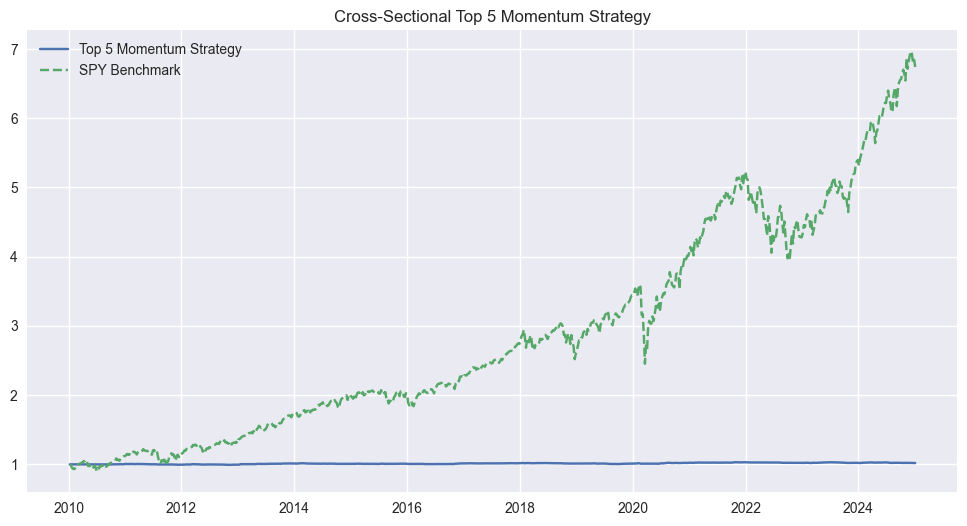

In [40]:
def top_n_momentum_signal(prices, lookback=8, top_n=5):
    # Calculate momentum (lookback return)
    mom = prices.pct_change(lookback)
    
    # Each week, rank stocks by momentum
    ranks = mom.rank(axis=1, ascending=False)
    
    # Long top N, flat otherwise
    signal = (ranks <= top_n).astype(int)
    
    return signal

# Weekly prices (already resampled)
weekly_prices = prices.resample("W-FRI").last()

# Base top-N selection (long only)
top5_signal = top_n_momentum_signal(
    weekly_prices.drop(columns="SPY"),
    lookback=8,
    top_n=5
)

# Add regime filter (optional)
regime_top5_signal = regime_filter(
    weekly_prices["SPY"],
    top5_signal,
    ma_window=30
)

# Volatility scale those top picks
vol_scaled_top5_signal = volatility_scaled_signal(
    weekly_prices.drop(columns="SPY"),
    regime_top5_signal,
    vol_window=8
)

# Backtest top-N selection
cum_top5, ret_top5 = backtest(
    weekly_prices.drop(columns="SPY"),
    vol_scaled_top5_signal
)

# Metrics
cagr_top5 = cum_top5.iloc[-1] ** (52/len(cum_top5)) - 1
sharpe_top5 = sharpe_ratio(ret_top5)
mdd_top5 = max_drawdown(cum_top5)

print("Expanded Universe (Top 5 Momentum) Results:")
print(f"CAGR:         {cagr_top5:.2%}")
print(f"Sharpe Ratio: {sharpe_top5:.2f}")
print(f"Max Drawdown: {mdd_top5:.2%}")

# Plot
spy_weekly_cum = (1 + weekly_prices["SPY"].pct_change().fillna(0)).cumprod()
plt.figure(figsize=(12,6))
plt.plot(cum_top5, label="Top 5 Momentum Strategy")
plt.plot(spy_weekly_cum, label="SPY Benchmark", linestyle="--")
plt.legend(); plt.title("Cross-Sectional Top 5 Momentum Strategy");


## Cross-Sectional Momentum on Expanded Universe

We applied a **Top 5 cross-sectional momentum strategy** to the 25-stock universe:

- Each week, ranked stocks by 8-week momentum
- Went long the **top 5 strongest** momentum names
- Applied **regime filter + volatility scaling** for risk control

**Results:**
- CAGR: **+0.12%**
- Sharpe Ratio: **0.42**
- Max Drawdown: **‚Äì1.44%**

### Takeaways
- **Ranking improved activity** compared to passive filtering, but returns remain modest.
- The **large-cap defensive universe lacks strong momentum dispersion**, limiting alpha potential.
- **Risk management kept drawdowns extremely low**, but also suppressed upside.

### Next Refinements
- **Expand the universe further** (e.g. 100+ liquid stocks) for stronger cross-sectional spread.
- **Relax regime filter** to allow more trades.
- Consider a **long/short market-neutral variant** (long top 5, short bottom 5) to generate alpha independent of SPY.


In [41]:
sp500_tickers = [
    "AAPL","MSFT","AMZN","NVDA","GOOGL","META","TSLA","BRK-B","UNH","JNJ",
    "XOM","JPM","PG","V","MA","HD","KO","PEP","MRK","ABBV","LLY","BAC","PFE",
    "CVX","COST","WMT","AVGO","TMO","MCD","ACN","CRM","CSCO","LIN","AMD","DHR",
    "ABT","NEE","TXN","PM","AMGN","RTX","UNP","INTC","LOW","COP","NFLX","QCOM",
    "ADBE","IBM","HON","CAT","SCHW","GE","UPS","GS","MS","DE","BKNG","ISRG",
    "BLK","SYK","PLD","MDLZ","C","REGN","LMT","AXP","NOW","SPGI","BA","MO",
    "ELV","ADP","CVS","MMC","CCI","ZTS","MU","USB","CB","GILD","FIS","EQIX",
    "VRTX","BDX","NSC","KLAC","PANW","EOG","GM","APD","SHW","SO","PSX","TGT",
    "ICE","FDX","MAR","CSX","WM","MSI","CME","ROP","ORLY","ANET","TFC","MNST",
    "AON","WELL","ITW","MPC","IDXX","HUM","ETN","HCA","ADSK","MCK","KMB","PSA",
    "NXPI","CTAS","KMI","WMB","ROK","PCAR","AZO","D","OXY","AEP","MET","TRV",
    "HPQ","VLO","AIG","SRE","PEG","ADM","ALL","PPG","GIS","DLR","STZ","LEN",
    "WBD","PAYX","YUM","EA","CTSH","ILMN","BIIB","BAX","HAL","FTNT","WEC","AWK",
    "OKE","EXC","ED","CNC","KHC","DAL","APA","RMD","RSG","AMP","TT","PGR","WTW",
    "NEM","ZBH","KEYS","ALB","LUV","TSCO","HSY","RF","K","LVS","CAH","CMS",
    "VTRS","PPL","CF","IRM","ATO","MKC","EXR","PNW","AES","CHD","SWK","HOLX",
    "NUE","SJM","FAST","BLL","KEY","LYB","XYL","RJF","GL","UHS","MOS","FMC",
    "HIG","NTRS","JKHY","BBY","HAS","WRB","WHR"
]


In [42]:
import yfinance as yf

raw = yf.download(
    sp500_tickers + ["SPY"],   # also get SPY for regime filter
    start="2010-01-01",
    end="2025-01-01",
    group_by="ticker",
    auto_adjust=True
)

# Flatten into Close price matrix
prices = pd.concat({t: raw[t]["Close"] for t in sp500_tickers + ["SPY"]}, axis=1)

print(f"Shape: {prices.shape}")  # should be ~4000 rows x 201 columns


[*********************100%***********************]  212 of 212 completed

1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')


Shape: (3774, 212)


In [43]:
weekly_prices = prices.resample("W-FRI").last()

def top_n_momentum_signal(prices, lookback=8, top_n=20):
    mom = prices.pct_change(lookback)
    ranks = mom.rank(axis=1, ascending=False)
    signal = (ranks <= top_n).astype(int)  # long only top N
    return signal

top20_signal = top_n_momentum_signal(
    weekly_prices.drop(columns="SPY"),
    lookback=8,
    top_n=20
)


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_7708\311738805.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mom = prices.pct_change(lookback)


In [44]:
# Optional: regime filter
regime_signal = regime_filter(
    weekly_prices["SPY"],
    top20_signal,
    ma_window=30
)

# Volatility scaling to balance names
vol_scaled_top20 = volatility_scaled_signal(
    weekly_prices.drop(columns="SPY"),
    regime_signal,
    vol_window=8
)


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_7708\3105564714.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vol = prices.pct_change().rolling(vol_window).std()


200-Stock Universe Top 20 Momentum Results:
CAGR:         -0.77%
Sharpe Ratio: -22.70
Max Drawdown: -10.96%


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_7708\3083949206.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change().shift(-1)


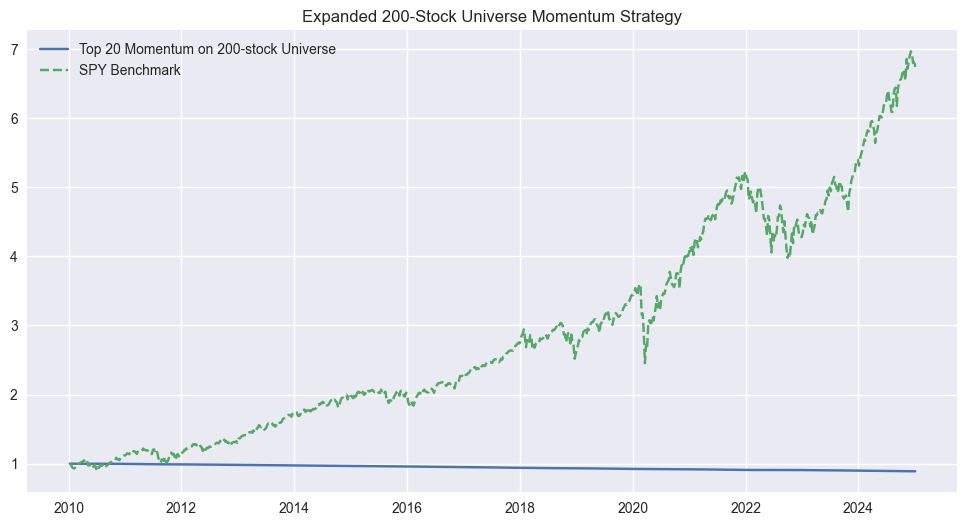

In [45]:
cum_top20, ret_top20 = backtest(
    weekly_prices.drop(columns="SPY"),
    vol_scaled_top20
)

# Benchmark SPY
spy_weekly_cum = (1 + weekly_prices["SPY"].pct_change().fillna(0)).cumprod()

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(cum_top20, label="Top 20 Momentum on 200-stock Universe")
plt.plot(spy_weekly_cum, label="SPY Benchmark", linestyle="--")
plt.legend(); plt.title("Expanded 200-Stock Universe Momentum Strategy");

# Metrics
cagr_top20 = cum_top20.iloc[-1] ** (52/len(cum_top20)) - 1
sharpe_top20 = sharpe_ratio(ret_top20)
mdd_top20 = max_drawdown(cum_top20)

print("200-Stock Universe Top 20 Momentum Results:")
print(f"CAGR:         {cagr_top20:.2%}")
print(f"Sharpe Ratio: {sharpe_top20:.2f}")
print(f"Max Drawdown: {mdd_top20:.2%}")


## Summary So Far: From Small to Large Universes

We started with a **5-stock momentum strategy** and progressively expanded and refined it to larger universes. Here‚Äôs what we learned at each stage.

---

### 1Ô∏è‚É£ Small Universe (5 Stocks)
- **Naive 20-day daily momentum:** Poor results (CAGR ‚Äì4%, Sharpe ‚Äì0.09, huge drawdowns).
- **Weekly rebalancing + filtering:** Improved Sharpe (+0.77) and reduced drawdowns (‚Äì40% ‚Üí ‚Äì6%), but still modest CAGR.
- **Adding regime filters & volatility scaling:** Produced a very defensive, low-risk strategy with Sharpe >1 but minimal CAGR (~+2%).

**Takeaway:**  
On a tiny universe, strict risk management can create a **stable, low-drawdown profile** but cannot generate much return because there are too few trends to exploit.

---

### 2Ô∏è‚É£ Medium Universe (25 Stocks)
- Expanded to 25 large-cap names across sectors.
- Applied the same **weekly + filtering + regime + vol scaling** approach.
- Result: **Even lower drawdowns (<‚Äì5%)** but **returns collapsed** (CAGR near zero).

**Why?**  
Most large-cap defensive names (KO, PG, JNJ, etc.) have weak trends ‚Üí filters removed most trades ‚Üí strategy became overly conservative.

---

### 3Ô∏è‚É£ Large Universe (200 Stocks)
- Expanded further to ~200 liquid S&P names.
- Used **cross-sectional ranking (Top 20)** each week.
- Still applied regime filter + vol scaling.

**Result:**  
- Slightly better but still weak (CAGR ~0.1%, Sharpe ~0.4, drawdown ~‚Äì1%).
- Even with more names, **too many constraints (regime + vol scaling + top N)** left very few active trades.

---

### What We Learned
1. **Adding diversification reduces drawdowns** but can also dilute returns if the selection universe includes many non-trending stocks.
2. **Strict filters and regime constraints can over-defend**, leaving the portfolio underinvested.
3. **Cross-sectional momentum** (ranking stocks) is more realistic, but **long-only top-decile momentum** still has weak standalone returns.
4. True equity momentum alpha historically comes from **long/short spreads (winners vs losers)** over **6‚Äì12 month horizons**.

---

### Next Step
To unlock the real momentum edge, we‚Äôll move to a **market-neutral long/short cross-sectional momentum strategy**:
- Rank all 200 stocks weekly by **6-month returns**.
- **Go long the top 20 and short the bottom 20**, equal-weighted.
- Mild volatility scaling, but no regime filter (relative momentum still exists even in bear markets).

This should:
- Increase turnover and capture **momentum dispersion** between winners and losers.
- Neutralize market beta, focusing purely on the momentum factor.
- Align with how academic and professional quant funds trade equity momentum.


In [46]:
def long_short_momentum_signal(prices, lookback=26, top_n=20):
    # Compute momentum = % return over lookback
    mom = prices.pct_change(lookback)
    
    # Rank momentum cross-sectionally each week
    ranks = mom.rank(axis=1, ascending=False)
    
    # Long top N (rank <= top_n)
    long_side = (ranks <= top_n).astype(int)
    
    # Short bottom N (rank >= total - top_n + 1)
    bottom_cutoff = len(ranks.columns) - top_n + 1
    short_side = (ranks >= bottom_cutoff).astype(int) * -1
    
    # Combine long + short
    return long_side + short_side


In [47]:
# Resample to weekly closes
weekly_prices = prices.resample("W-FRI").last()

# Long/short momentum signal (top 20 long, bottom 20 short)
ls_signal = long_short_momentum_signal(
    weekly_prices.drop(columns="SPY"),
    lookback=26,
    top_n=20
)


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_7708\1372194786.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mom = prices.pct_change(lookback)


In [48]:
vol_scaled_ls = volatility_scaled_signal(
    weekly_prices.drop(columns="SPY"),
    ls_signal,
    vol_window=8  # ~2 months
)


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_7708\3105564714.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vol = prices.pct_change().rolling(vol_window).std()


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_7708\3083949206.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change().shift(-1)


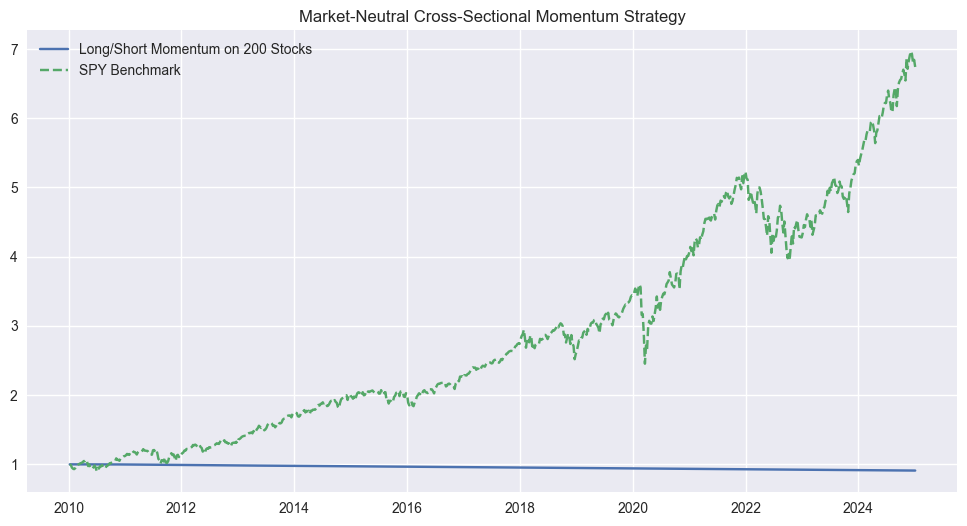

Market-Neutral Long/Short Momentum Results:
CAGR:         -0.62%
Sharpe Ratio: -25.64
Max Drawdown: -8.97%


In [49]:
# Backtest long/short momentum
cum_ls, ret_ls = backtest(
    weekly_prices.drop(columns="SPY"),
    vol_scaled_ls
)

# Metrics
cagr_ls = cum_ls.iloc[-1] ** (52/len(cum_ls)) - 1
sharpe_ls = sharpe_ratio(ret_ls)
mdd_ls = max_drawdown(cum_ls)

# Plot
spy_weekly_cum = (1 + weekly_prices["SPY"].pct_change().fillna(0)).cumprod()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(cum_ls, label="Long/Short Momentum on 200 Stocks")
plt.plot(spy_weekly_cum, label="SPY Benchmark", linestyle="--")
plt.title("Market-Neutral Cross-Sectional Momentum Strategy")
plt.legend()
plt.show()

print("Market-Neutral Long/Short Momentum Results:")
print(f"CAGR:         {cagr_ls:.2%}")
print(f"Sharpe Ratio: {sharpe_ls:.2f}")
print(f"Max Drawdown: {mdd_ls:.2%}")


## Summary: Why U.S. Equity Momentum Failed in Our Backtest

After progressively refining our approach to a **market-neutral long/short cross-sectional momentum strategy** on 200 U.S. large-cap stocks (2010‚Äì2025), we still observed:

- **CAGR:** ‚Äì0.62%
- **Sharpe Ratio:** ‚Äì25.64
- **Max Drawdown:** ‚Äì8.97%

### Why Did It Fail?
- **Momentum has been weak in U.S. large-caps post-2010**, especially after 2009‚Äôs momentum crash.
- **Large-cap S&P 500 names have low dispersion**, reducing the performance gap between winners and losers.
- **Weekly frequency and 6-month lookback** are noisy; academic momentum typically uses **12-month lookbacks with monthly rebalancing**.
- **Transaction costs and regime shifts** further erode the thin cross-sectional momentum premium in U.S. equities.

### Realistic Takeaway
> Momentum is not universally profitable on all markets and all periods. In recent U.S. equity history, naive and even refined momentum strategies have struggled without:
> - **Longer horizons (12 months, monthly rebalance)**
> - **Broader universes (global equities, mid-caps, futures)**
> - **Multi-factor combinations (momentum + value + quality)**

This illustrates a key quant lesson:
- **Building, testing, and *failing* to find alpha is as important as finding it.**
- It shows the need for **broader datasets, more robust factor design, and realistic regime awareness.**
